In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_label_accuracies(true_labels, predicted_labels, title):
    predicted_labels = np.array(predicted_labels)
    
    unique_labels = np.unique(true_labels)
    
    plt.figure(figsize=(10, 7))
    
    overall_accuracy = np.mean(predicted_labels == true_labels) * 100

    for i, label in enumerate(unique_labels):
        label_indices = np.where(true_labels == label)[0]
        
        label_predicted_labels = predicted_labels[label_indices]
        
        label_accuracy = np.mean(label_predicted_labels == label) * 100
        
        bar = plt.bar(str(label), label_accuracy, color='skyblue')
        
        plt.text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height(), f'{label_accuracy:.2f}%', 
                 ha='center', va='bottom')

    plt.text(0.95, 0.95, f'Overall Accuracy: {overall_accuracy:.2f}%', transform=plt.gca().transAxes, 
             ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.title(title)
    plt.xlabel('True Label')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)  # Optionally set limits to make the scale from 0% to 100%
    plt.yticks(np.arange(0, 101, 10), [f'{i}%' for i in range(0, 101, 10)])
    plt.show()

In [2]:
from sklearn.decomposition import PCA
def use_pca(X_train_hog, X_test_hog):
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_hog)
    X_test_pca = pca.transform(X_test_hog)
    return X_train_pca, X_test_pca

## Functions

In [3]:
from skimage.feature import hog

image_height = 48
image_width = 48
window_size = 24
window_step = 6

def sliding_hog_windows(image):
    hog_windows = []
    for y in range(0, image_height, window_step):
        for x in range(0, image_width, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1,1)))
    return hog_windows

def get_hog_window_features(images):
    hog_features = []
    
    for image in images:
        features = sliding_hog_windows(image)
        hog_features.append(features)
    return hog_features

In [4]:
import os
import cv2
import numpy as np

def load_images_from_folder_fer_2013(folder, max_images_per_class=None):
    images = []
    labels = []
    for label_folder in os.listdir(folder):
        label_folder_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_folder_path):
            count_images_for_class = 0
            print("label_folder_path: ", label_folder_path)
            for image_file in os.listdir(label_folder_path):
                if max_images_per_class is not None and count_images_for_class >= max_images_per_class:
                    print(f"Reached maximum number of images for class {label_folder}. Skipping the rest.")
                    break
                count_images_for_class += 1
                image_path = os.path.join(label_folder_path, image_file)
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (48, 48))
                # images.append(img.flatten())
                images.append(img)
                labels.append(label_folder)
    return np.array(images), np.array(labels)


def prepare_X_y(max_images_per_class=None):
    train_folder = '/Users/gurcan/Desktop/School/Bil468/FaceEmotionProject/Data/merged/train'
    test_folder = '/Users/gurcan/Desktop/School/Bil468/FaceEmotionProject/Data/merged/validation'
    images_train, labels_train = load_images_from_folder_fer_2013(train_folder, max_images_per_class)
    images_test, labels_test = load_images_from_folder_fer_2013(test_folder, max_images_per_class)
    X = np.concatenate((images_train, images_test), axis=0)
    y = np.concatenate((labels_train, labels_test), axis=0)
    return X, y

In [5]:
X, y = prepare_X_y(max_images_per_class=5000)

label_folder_path:  /Users/gurcan/Desktop/School/Bil468/FaceEmotionProject/Data/merged/train/happy
Reached maximum number of images for class happy. Skipping the rest.
label_folder_path:  /Users/gurcan/Desktop/School/Bil468/FaceEmotionProject/Data/merged/train/sad
Reached maximum number of images for class sad. Skipping the rest.
label_folder_path:  /Users/gurcan/Desktop/School/Bil468/FaceEmotionProject/Data/merged/train/fear
label_folder_path:  /Users/gurcan/Desktop/School/Bil468/FaceEmotionProject/Data/merged/train/surprise
Reached maximum number of images for class surprise. Skipping the rest.
label_folder_path:  /Users/gurcan/Desktop/School/Bil468/FaceEmotionProject/Data/merged/train/neutral
Reached maximum number of images for class neutral. Skipping the rest.
label_folder_path:  /Users/gurcan/Desktop/School/Bil468/FaceEmotionProject/Data/merged/train/angry
Reached maximum number of images for class angry. Skipping the rest.
label_folder_path:  /Users/gurcan/Desktop/School/Bil468/

In [6]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_hog_features = get_hog_window_features(X_train)
test_hog_features = get_hog_window_features(X_test)

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


def classify_with_knn(X_train, X_test, y_train, y_test, n_neighbors=5):
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)

    knn_classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred_knn = knn_classifier.predict(X_test)

    # Tahmin başarımını değerlendirme
    accuracy = accuracy_score(y_test, y_pred_knn)
    print(f'Test seti üzerindeki doğruluk: {accuracy:.2f}')
    return y_pred_knn

In [8]:
train_hog_features = np.array(train_hog_features)
test_hog_features = np.array(test_hog_features)

print(train_hog_features.shape)
print(test_hog_features.shape)

pca_train_hog, pca_test_hog = use_pca(train_hog_features, test_hog_features)


(42324, 2592)
(10582, 2592)


In [9]:
predictions = classify_with_knn(train_hog_features, test_hog_features, y_train, y_test, n_neighbors=30)

predictions_with_pca = classify_with_knn(pca_train_hog, pca_test_hog, y_train, y_test, n_neighbors=30)

Test seti üzerindeki doğruluk: 0.33
Test seti üzerindeki doğruluk: 0.33


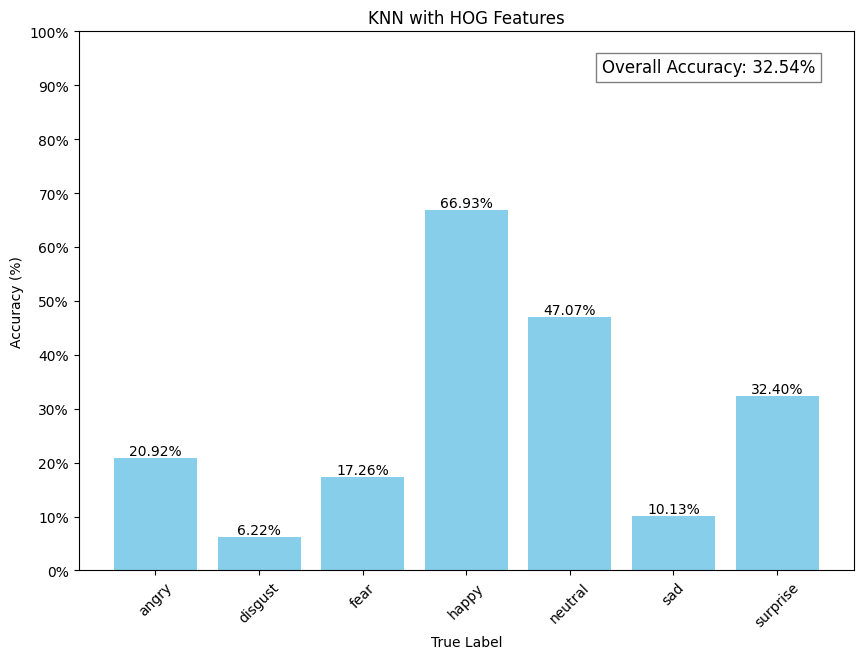

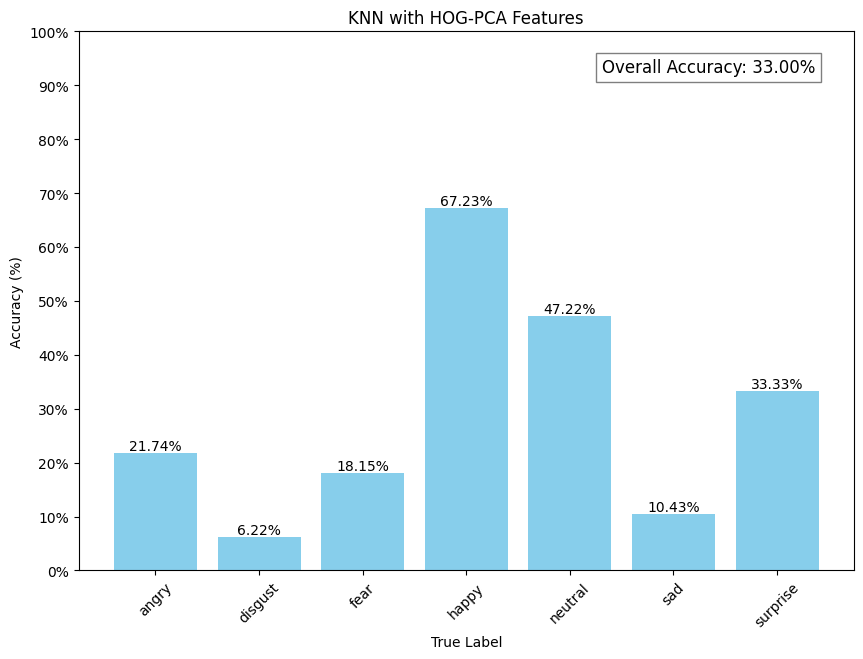

In [10]:
plot_label_accuracies(y_test, predictions, 'KNN with HOG Features')
plot_label_accuracies(y_test, predictions_with_pca, 'KNN with HOG-PCA Features')

In [11]:
# %pip install dlib
import dlib

predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
def get_landmarks(image, rects):
    # this function have been copied from http://bit.ly/2cj7Fpq
    if len(rects) > 1:
        raise BaseException("TooManyFaces")
    if len(rects) == 0:
        raise BaseException("NoFaces")
    return np.matrix([[p.x, p.y] for p in predictor(image, rects[0]).parts()])

In [12]:
def get_face_landmarks(images):
    landmarks = []
    for image in images:
        face_rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]
        face_landmarks = get_landmarks(image, face_rects)
        landmarks.append(face_landmarks)
    return landmarks

In [13]:
face_landmarks_train = get_face_landmarks(X_train)
face_landmarks_test = get_face_landmarks(X_test)

In [14]:
landmarks_flattened_train = np.squeeze(np.array([x.flatten() for x in face_landmarks_train]))
landmarks_flattened_test = np.squeeze(np.array([x.flatten() for x in face_landmarks_test]))

# HOG özellikleri ve düzleştirilmiş landmark'ları birleştirme
features_combined_train = np.concatenate((landmarks_flattened_train, train_hog_features), axis=1)
features_combined_test = np.concatenate((landmarks_flattened_test, test_hog_features), axis=1)

Test seti üzerindeki doğruluk: 0.32
Test seti üzerindeki doğruluk: 0.32


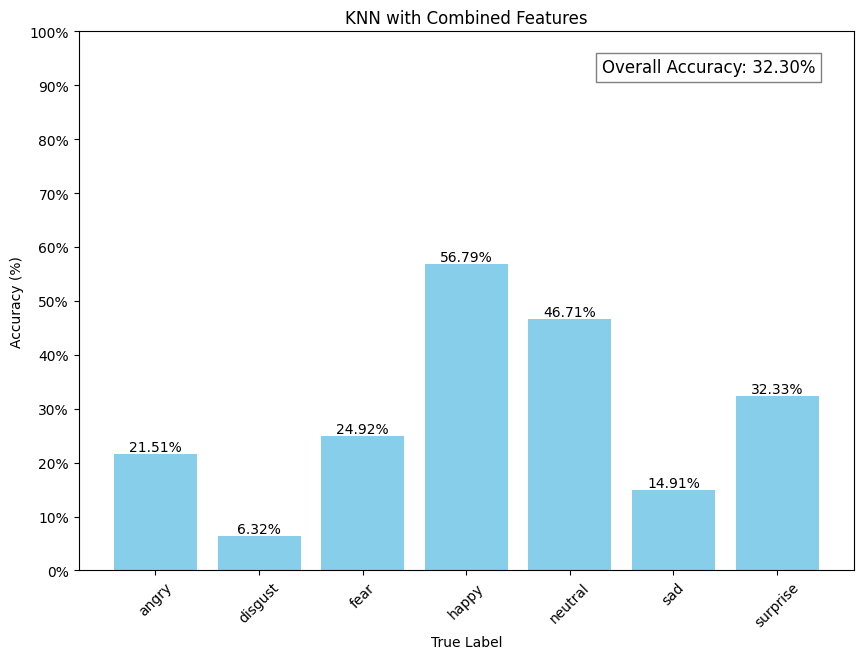

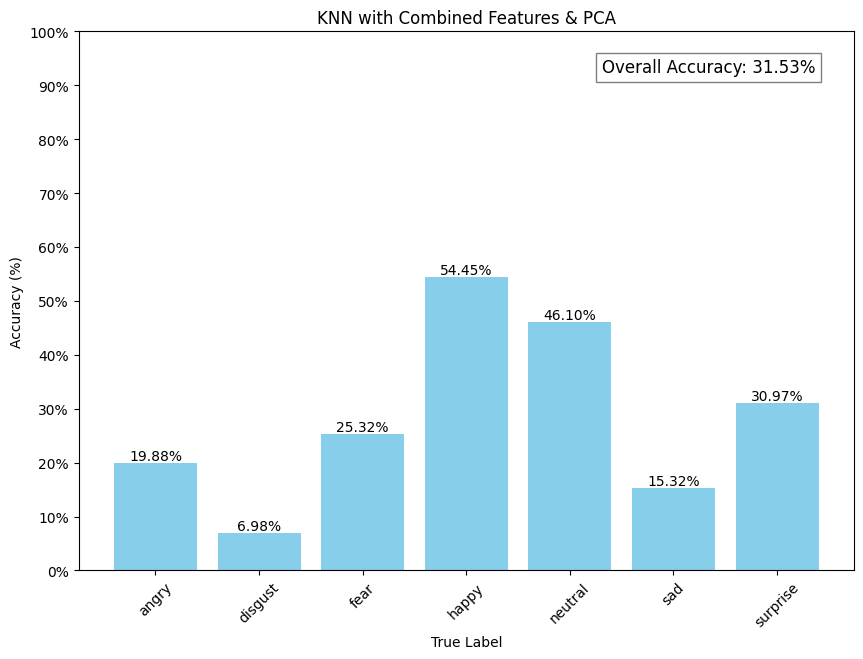

In [15]:
pca_combined_train, pca_combined_test = use_pca(features_combined_train, features_combined_test)
predictions_combined_pca = classify_with_knn(pca_combined_train, pca_combined_test, y_train, y_test, n_neighbors=30)
predictions_combined = classify_with_knn(features_combined_train, features_combined_test, y_train, y_test, n_neighbors=30)
plot_label_accuracies(y_test, predictions_combined, 'KNN with Combined Features')
plot_label_accuracies(y_test, predictions_combined_pca, 'KNN with Combined Features & PCA')